# Loading Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

# Load the Iris dataset from scikit-learn

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
print(iris)
X, y = iris.data, iris.target

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     

In [3]:
df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
df['target'] = iris['target']
df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


# Train Test Split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Scaling or Feature Selection

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# One Hot Encoding

In [6]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)
y_train_encoded = enc.fit_transform(y_train.reshape(-1,1))

# Class Distribution

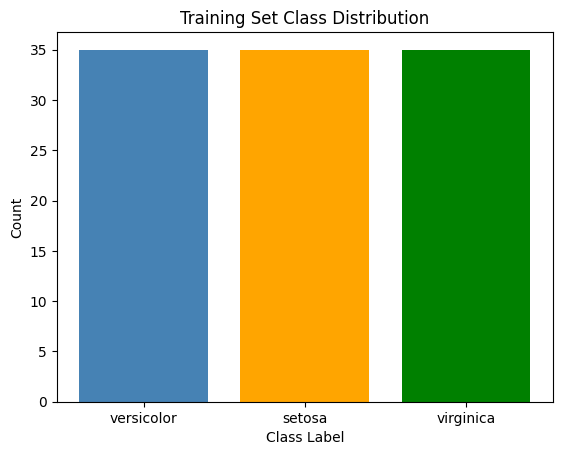

In [7]:
from collections import Counter
# Map target integers to class names
target_labels = iris.target_names
y_train_labeled = np.vectorize(lambda x: target_labels[x])(y_train)

# Count class distribution
train_counts = Counter(y_train_labeled)

# Bar plot
plt.bar(train_counts.keys(), train_counts.values(), color=['steelblue', 'orange', 'green'])
plt.xticks(rotation=0)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Training Set Class Distribution')
plt.show()

### Dataset is balanced

# Softmax Logistic Regression Implementation

In [8]:
class SoftmaxRegression:
    def __init__(self, learning_rate=0.1, epochs=1000, batch_size=None, random_state=None, tol=1e-6, verbose=False, reg_lambda=0.0):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.tol = tol
        self.verbose = verbose
        self.reg_lambda = reg_lambda
        self.W = None
        self.history_ = []
        self.val_history_ = []
        self.n_iter_ = 0

    @staticmethod
    def _softmax(z):
        z_max = np.max(z, axis=1, keepdims=True)
        exp = np.exp(z - z_max)
        sum_exp = np.sum(exp, axis=1, keepdims=True)
        return exp / sum_exp

    def fit(self, X, y, X_val=None, y_val=None, patience=5):
        randomizer = np.random.RandomState(self.random_state)
        n_samples, n_features = X.shape
        n_classes = y.shape[1]

        self.W = randomizer.normal(scale=0.01, size=(n_features + 1, n_classes))
        X = np.hstack([np.ones((n_samples, 1)), X])

        if self.batch_size is None:
            self.batch_size = n_samples

        prev_loss = np.inf
        best_val_loss = np.inf
        best_W = None
        no_improve_epochs = 0

        for epoch in range(1, self.epochs + 1):
            perm = randomizer.permutation(n_samples)
            Xb_shuf, Y_shuf = X[perm], y[perm]

            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                xb, yb = Xb_shuf[start:end], Y_shuf[start:end]

                logits = xb.dot(self.W)
                probs = self._softmax(logits)
                grad = xb.T.dot(probs - yb) / xb.shape[0]
                grad[1:] += (self.reg_lambda / n_samples) * self.W[1:]
                self.W -= self.learning_rate * grad

            # train loss
            logits_all = X.dot(self.W)
            probs_all = self._softmax(logits_all)
            log_probs = np.log(np.clip(probs_all, 1e-15, 1.0))
            l2_term = (self.reg_lambda / (2 * n_samples)) * np.sum(self.W[1:] ** 2)
            loss = -np.sum(y * log_probs) / n_samples + l2_term
            self.history_.append(loss)

            # val loss
            if X_val is not None and y_val is not None:
                Xv = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
                logits_val = Xv.dot(self.W)
                probs_val = self._softmax(logits_val)
                log_probs_val = np.log(np.clip(probs_val, 1e-15, 1.0))
                l2_term_val = (self.reg_lambda / (2 * X_val.shape[0])) * np.sum(self.W[1:] ** 2)
                val_loss = -np.sum(y_val * log_probs_val) / X_val.shape[0] + l2_term_val
                self.val_history_.append(val_loss)

                if val_loss < best_val_loss - 1e-6:
                    best_val_loss = val_loss
                    best_W = self.W.copy()
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1
                    if no_improve_epochs >= patience:
                        if self.verbose:
                            print(f"Early stopping at epoch {epoch} (no val improvement in {patience} epochs)")
                        break

            if self.verbose:
                msg = f"Epoch {epoch} -> train loss: {loss:.6f}"
                if X_val is not None and y_val is not None:
                    msg += f", val loss: {self.val_history_[-1]:.6f}"
                print(msg)

            if abs(prev_loss - loss) < self.tol:
                if self.verbose:
                    print(f"Training converged at epoch {epoch}")
                break
            prev_loss = loss

        if best_W is not None:
            self.W = best_W
        return self


    def _single_predict(self, x):
        probs = self._softmax(x.dot(self.W).reshape(1, -1))
        return np.argmax(probs, axis=1)[0]

    def predict(self, X):
        ones = np.ones((X.shape[0], 1), dtype=X.dtype)
        Xb = np.hstack([ones, X])
        probs = self._softmax(Xb.dot(self.W))
        return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        ones = np.ones((X.shape[0], 1), dtype=X.dtype)
        Xb = np.hstack([ones, X])
        return self._softmax(Xb.dot(self.W))


# Training SoftMax Logistic Regression 
### using L2 Legularization to find best fit for Learning Rate and Regularization Parameter

In [9]:
# params
learning_rates = np.linspace(1e-3, 1e-1, 5)
reg_lambdas = np.linspace(1e-4, 1e-1, 4)
best_fit_lr = np.inf
best_fit_reg_lambda = np.inf

In [10]:
X_val_scaled = scaler.transform(X_val)
y_val_encoded = enc.transform(y_val.reshape((y_val.size,1)))

#### Finding Best fit

In [11]:
from sklearn.metrics import accuracy_score

prev_acc = -np.inf
for lr in learning_rates:
    for reg_lambda in reg_lambdas:
        clf = SoftmaxRegression(learning_rate=lr, random_state=42, verbose=False, reg_lambda=reg_lambda)
        clf.fit(X=X_train_scaled, y=y_train_encoded, X_val=X_val_scaled, y_val=y_val_encoded)
        y_val_pred = clf.predict(X_val_scaled)
        acc = accuracy_score(y_true=np.argmax(y_val_encoded, axis=1), y_pred=y_val_pred)
        print(f'learning rate={lr:.4f}, reg_lambda={reg_lambda:.4f}: accuracy={acc:.3f}')
        if acc > prev_acc:
            prev_acc = acc
            best_fit_lr = lr
            best_fit_reg_lambda = reg_lambda
print(f'\n\nbest fit: learning_rate={best_fit_lr:.4f}, regularization lambda={best_fit_reg_lambda:.4f}')

learning rate=0.0010, reg_lambda=0.0001: accuracy=0.739
learning rate=0.0010, reg_lambda=0.0334: accuracy=0.739
learning rate=0.0010, reg_lambda=0.0667: accuracy=0.739
learning rate=0.0010, reg_lambda=0.1000: accuracy=0.739
learning rate=0.0258, reg_lambda=0.0001: accuracy=0.826
learning rate=0.0258, reg_lambda=0.0334: accuracy=0.826
learning rate=0.0258, reg_lambda=0.0667: accuracy=0.826
learning rate=0.0258, reg_lambda=0.1000: accuracy=0.826
learning rate=0.0505, reg_lambda=0.0001: accuracy=0.870
learning rate=0.0505, reg_lambda=0.0334: accuracy=0.870
learning rate=0.0505, reg_lambda=0.0667: accuracy=0.870
learning rate=0.0505, reg_lambda=0.1000: accuracy=0.870
learning rate=0.0753, reg_lambda=0.0001: accuracy=0.957
learning rate=0.0753, reg_lambda=0.0334: accuracy=0.957
learning rate=0.0753, reg_lambda=0.0667: accuracy=0.957
learning rate=0.0753, reg_lambda=0.1000: accuracy=0.957
learning rate=0.1000, reg_lambda=0.0001: accuracy=0.957
learning rate=0.1000, reg_lambda=0.0334: accurac

## Model with best hyperparameters

In [12]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.vstack([y_train.reshape((y_train.shape[0],1)), y_val.reshape((y_val.shape[0],1))])

# Scale features
best_fit_scaler = StandardScaler()
X_train_full_scaled = best_fit_scaler.fit_transform(X_train_full)

# Encode targets
best_fit_enc = OneHotEncoder(sparse_output=False)
y_train_full_encoded = best_fit_enc.fit_transform(y_train_full)

# Train final model with best hyperparameters
best_clf_my_impl = SoftmaxRegression(learning_rate=best_fit_lr, random_state=42, verbose=False, reg_lambda=best_fit_reg_lambda)

best_clf_my_impl.fit(X=X_train_full_scaled, y=y_train_full_encoded)

# Prediction Performance Report

In [13]:
X_test_scaled = scaler.transform(X_test)
y_test_encoded = enc.transform(y_test.reshape((y_test.shape[0], 1)))
y_test_pred = best_clf_my_impl.predict(X_test_scaled)

# accuracy
accuracy = accuracy_score(y_pred=y_test_pred, y_true=y_test)
print(f'accuracy score {accuracy}')

accuracy score 0.8636363636363636


#### Confusion Matrix

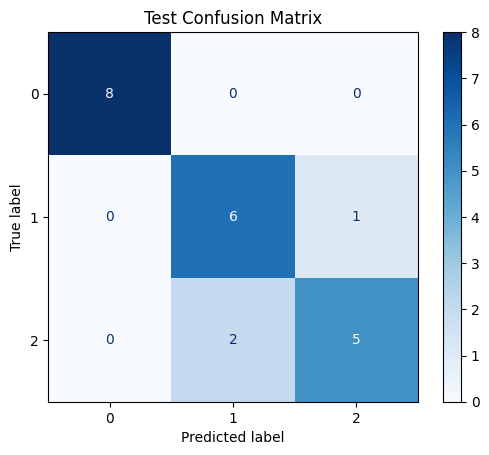

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cnf_mat = confusion_matrix(y_pred=y_test_pred, y_true=y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mat)
disp.plot(cmap='Blues')
plt.title("Test Confusion Matrix")
plt.show()

#### Precision and Recall

In [15]:
from sklearn.metrics import precision_score, recall_score

# Precision and Recall
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')

print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")

Precision : 0.8611
Recall    : 0.8571


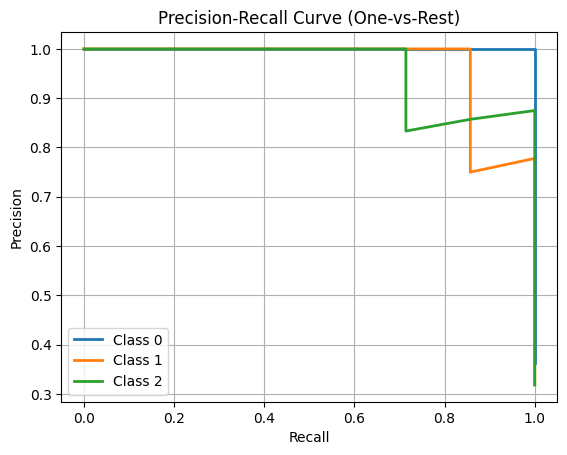

In [16]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_test_pred_proba = best_clf_my_impl.predict_proba(X_test_scaled)
n_classes = y_val_encoded.shape[1]
plt.figure()

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_encoded[:, i], y_test_pred_proba[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()

# Fiting Scikit-learn model on best hyper-params

In [17]:
from sklearn.linear_model import LogisticRegression

C = 1.0 / best_fit_reg_lambda

best_clf_sklearn = LogisticRegression(multi_class='multinomial',penalty="l2", C=C, random_state=42)
best_clf_sklearn.fit(X=X_train_full_scaled, y=y_train_full)

e:\Python_projs\ML_labs\.venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\Python_projs\ML_labs\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,np.float64(10000.0)
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'multinomial'


# Comparision

In [18]:
# predict
sk_y_test_pred = best_clf_sklearn.predict(X_test_scaled)
sk_y_test_pred_proba = best_clf_sklearn.predict_proba(X_test_scaled)
# accuracy
sk_accuracy_score = accuracy_score(y_test, sk_y_test_pred)
# confusion matrix
sk_cnf_mat = confusion_matrix(y_test, sk_y_test_pred)
# precision
sk_precision = precision_score(y_test, sk_y_test_pred, average='macro')
# recall
sk_recall = recall_score(y_test, sk_y_test_pred, average='macro')

### Accuracy Score

In [19]:
print(f'sklearn accuracy score: {sk_accuracy_score}')
print(f'my implementation accuracy score: {accuracy}')

sklearn accuracy score: 0.8636363636363636
my implementation accuracy score: 0.8636363636363636


### Confusion Matrix

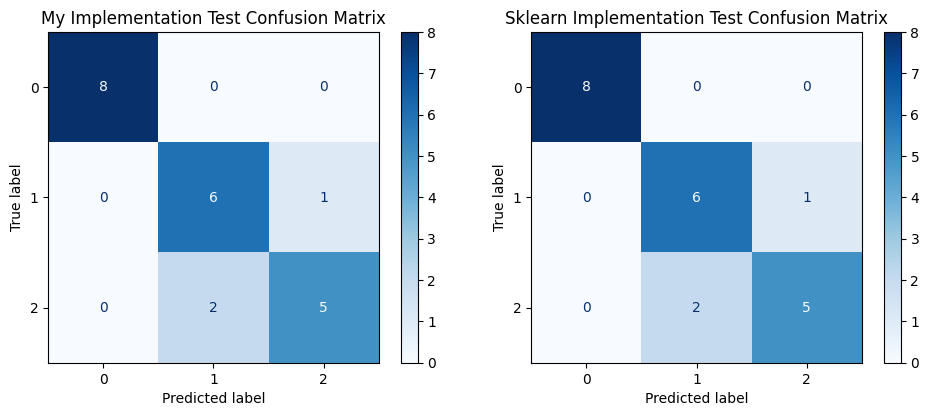

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cnf_mat)
disp1.plot(cmap='Blues', ax=axes[0])
axes[0].set_title("My Implementation Test Confusion Matrix")

disp2 = ConfusionMatrixDisplay(confusion_matrix=sk_cnf_mat)
disp2.plot(cmap='Blues', ax=axes[1])
axes[1].set_title("Sklearn Implementation Test Confusion Matrix")

plt.tight_layout()
plt.show()

### Precision and Recall

In [21]:
impl_precision = precision_score(y_test, y_test_pred, average='macro')
impl_recall = recall_score(y_test, y_test_pred, average='macro')

precision_recall_df = pd.DataFrame([
    {
        'implementation': 'sklearn',
        'precision': sk_precision,
        'recall': sk_recall
    },
    {
        'implementation': 'my impl',
        'precision': impl_precision,
        'recall': impl_recall
    }
])

print(precision_recall_df)

  implementation  precision    recall
0        sklearn   0.861111  0.857143
1        my impl   0.861111  0.857143


### Precission-Recall Curve

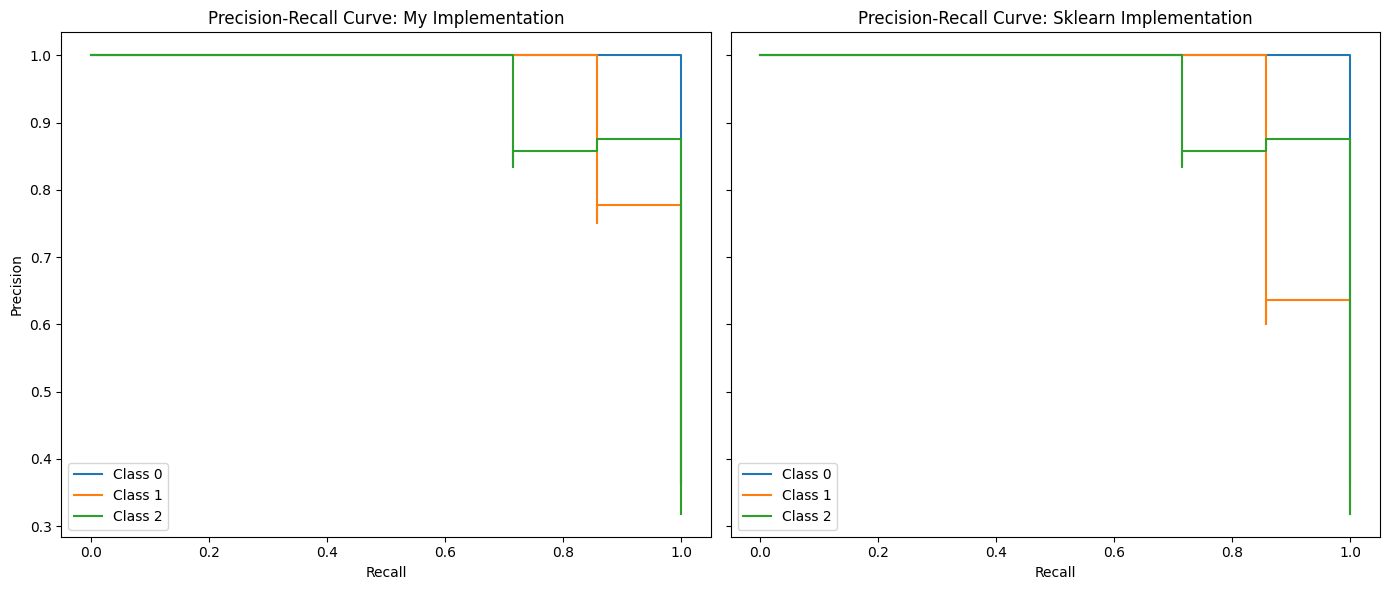

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

n_classes = y_test_pred_proba.shape[1]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i in range(n_classes):
    # My implementation
    precision_impl, recall_impl, _ = precision_recall_curve(y_test == i, y_test_pred_proba[:, i])
    axes[0].step(recall_impl, precision_impl, where='post', label=f'Class {i}')
    
    # Sklearn implementation
    precision_sk, recall_sk, _ = precision_recall_curve(y_test == i, sk_y_test_pred_proba[:, i])
    axes[1].step(recall_sk, precision_sk, where='post', label=f'Class {i}')

axes[0].set_title("Precision-Recall Curve: My Implementation")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].legend()

axes[1].set_title("Precision-Recall Curve: Sklearn Implementation")
axes[1].set_xlabel("Recall")
axes[1].legend()

plt.tight_layout()
plt.show()
